In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timeit
import time
from english_words import english_words_set

## Conjuntos de Palabras

In [2]:
N=600
array=[set()]*N
i=0
for x in english_words_set:
    if i<N:
        if i==0:
            array[i]={x}
        else:
            array[i]=array[i-1].union({x})
    i=i+1
for i in np.arange(len(array)-1):
    if not array[i].issubset(array[i+1]):
        print("ERROR")
H=(1,1)
vert=np.array(array).reshape(600,1)
horz=np.array(array).reshape(1,600)

In [3]:
def kernel_u(w):
    """
    univariate gaussian kernel
    
    Arguments:
    w :: float
    
    returns:
    float
    N(0,1)(w) mean zero unit variance normal distribution on w
    """
    return np.exp(-0.5*w**2)/np.sqrt(2*np.pi)
def kernel_b(u,v):
    """
    bivariate gaussian kernel
    
    Arguments:
    u,v :: float
    
    returns:
    float
    N(0,0,1,1,0)(u,v) bivariate standard normal distribution on (u,v)
    """
    return np.exp(-0.5*(u**2 + v**2))/np.sqrt(2*np.pi)
def d(x,y):
    """
    Metric function
    
    Arguments:
    x,y sets
    
    returns:
    float
    the distance between x and y elements of a metric space
    """
    return len(x.symmetric_difference(y))
d_vec=np.vectorize(d)
"""
vectorized metric function d(X,Y)
Arguments
X :: set
Y :: array sets

returns:
array float
the distance between X and ith Y' entry 
"""

"\nvectorized metric function d(X,Y)\nArguments\nX :: set\nY :: array sets\n\nreturns:\narray float\nthe distance between X and ith Y' entry \n"

In [4]:
def old_density_est(V,W):
    n=len(array)
    sum=0       # sum to calculate density estimator
    for i in np.arange(0,n):
        u = d(V,array[i])/H[0]  # compute the fisrt parameter to pass to bivariate kernel
        v = d(W,array[i])/H[1]  # compute the second parameter to pass to bivariate kernel
        sum+=kernel_b(u,v)     #sum the kernel estimations
    return sum/(n*H[0]*H[1]) # return the mean of kernel estimations times det of bandwitdh matrix
def density_est(V,W):
    array1=kernel_u(d_vec(V,horz)/H[0])
    array2=kernel_u(d_vec(vert,W)/H[1])
    return np.dot(array1,array2)/(len(array)*H[0]*H[1]) # return the mean of kernel estimations times det of bmatrix
###################################################################################################################
###################################################################################################################
###################################################################################################################
def old_marginal_est(W):
    sum=0       # sum to calculate density estimator
    for V in array:
        sum+=old_density_est(V,W) #sum the kernel estimations
    return sum
def marginal_est(W):
    arr=density_est(vert,W) #sum the kernel estimations
    return np.sum(arr)
def conditional_prob(V,W):
    return density_est(V,W)/marginal_est(W)

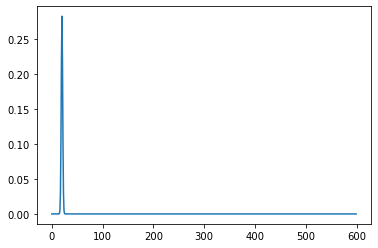

In [16]:
plt.plot(conditional_prob(vert,array[20]))

In [15]:
for n in range(5):
    %timeit old_density_est(array[n],array[287])
    %timeit density_est(array[n],array[287])
    %timeit old_marginal_est(array[n])
    %timeit marginal_est(array[n])
    print("==========================")

7.07 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.81 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.73 s ± 78.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.65 s ± 146 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.86 ms ± 396 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.3 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.84 s ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.56 s ± 26.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.16 ms ± 88.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.05 ms ± 355 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.87 s ± 35.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.77 s ± 34.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.62 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.14 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.7 s ± 169 ms per loop (m

In [ ]:
oldD=np.zeros(600)
newD=np.zeros(600)
oldM=np.zeros(600)
newM=np.zeros(600)
value=array[287]
for n in range(600):
    a=array[n]
    oldD[n]=timeit.Timer('old_density_est(array[n],array[287])','from __main__ import add, a, value').timeit()
    #newD[i]=timeit.Timer(density_est(array[n],array[287]))
    #oldM[i]=timeit.Timer(old_marginal_est(array[n],array[287]))
    #newM[i]=timeit.Timer(marginal_est(array[n],array[287]))
plt.plot(np.arange(1,601),oldD, color='black', linestyle='dotted',label='oldD')
#plt.plot(np.arange(1,601),newD, color='red', linestyle='dashed', label='newD')
#plt.plot(np.arange(1,601),oldM, color='green', linestyle='solid', label='oldM')
#plt.plot(np.arange(1,601),newM, color='blue', linestyle='dashdot', label='newM')
plt.show()

In [ ]:
import benchit
funcs = [dot1, dot2, dot3, dot4, dot5, dot6]
inputs = {n: gen(n, 100) for n in [100,1000,10000,100000,1000000]}

t = benchit.timings(funcs, inputs, multivar=True, input_name='Number of operators')
t.plot(logy=True, logx=True)

## Plots

In [ ]:
output=np.zeros(len(array))
for i in np.arange(len(array)):
    output[i]=marginal_est(array[i])
plt.plot(labels, output)
plt.title("Marginal calculada con el nuevo estimador")

In [ ]:
heatmap=np.zeros((len(array),len(array)))
bandwidth_matrix=[100,100]
for i in np.arange(len(array)):
    for j in np.arange(len(array)):
        heatmap[i,j]=new_density_est(array[i],array[j])
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.title("Densidad calculada con el nuevo estimador")


    @property
    def bandwidth(self):
        return self._bandwidth
    @bandwidth.setter
    def bandwidth(self, value):
        if not isinstance(value, float):
            raise TypeError('RandomSets.bandwidth must be a float')
        self._bandwidth = value

In [ ]:
def old_marginal_est(X):
    """
    Marginal estimation
    
    Arguments:
    set
    X argument for estimation
    
    returns:
    float
    the marginal density estimation on X
    """
    sum=0       # sum to calculate density estimator
    for x in Xi:
        sum+=old_density_est(x,X,array,array,H) #sum the kernel estimations
    return sum
def old_density_est(X,Y, Xi, Yi, H):
    """
    density estimation
    
    Arguments:
    sets
    (X,Y) vector for estimation
    np.array:
    Xi, Yi histogram bins (bivariate case)
    np.array:
    H 'matrix' of bandwidths
    
    returns:
    float
    the total density estimation on X,Y
    """
    n=len(Xi)
    sum=0       # sum to calculate density estimator
    for i in np.arange(0,n):
        u = d(X,Xi[i])/H[0]  # compute the fisrt parameter to pass to bivariate kernel
        v = d(Y,Yi[i])/H[1]  # compute the second parameter to pass to bivariate kernel
        sum+=kernel_b(u,v)     #sum the kernel estimations
    return sum/(n*H[0]*H[1]) # return the mean of kernel estimations times det of bandwitdh matrix
def marginal_est(X):
    """
    Marginal estimation
    
    Arguments:
    set
    X argument for estimation
    np.array:
    Xi array of histogram bins
    float:
    h bandwidth
    
    returns:
    float
    the marginal density estimation on X
    """
    arg=kernel_u(d_vec(X,Xi)/h)
    return np.sum(arg)/(len(Xi)*h)       # return the mean of kernel estimations times bandwitdh
def density_est(X,Y, Xi, Yi, H):
    """
    density estimation
    
    Arguments:
    float
    X,Y vector for estimation
    list:
    Xi, Yi histogram bins (bivariate case)
    np.array:
    H 'matrix' of bandwidths
    
    returns:
    float
    the total density estimation on X,Y
    """
    
    array1=kernel_u(d_vec(X,Xi)/H[0])
    array2=kernel_u(d_vec(Y,Yi)/H[1])
    return np.dot(array1,array2)/(len(Xi)*H[0]*H[1]) # return the mean of kernel estimations times det of bmatrix